In [1]:
import glob
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import dates as mpl_dates
from sklearn import preprocessing as prep
from scipy.stats import pearsonr

In [2]:
#wind turbine dataset
turbine_data = pd.read_csv("windturbines.csv")

In [3]:
#wind power produced dataset
wind_power_data = pd.read_csv('windpower_task0_updated.csv')

#rename time series column and remove timezone
wind_power_data = wind_power_data.rename(columns= {'Unnamed: 0' : 'time'},)
dt= wind_power_data.time
wind_power_data.time = pd.to_datetime(wind_power_data.time).dt.tz_localize(None)
#plt.plot(wind_power_data.SE3)

In [4]:
#weather dataset over SE3 region
# '2000 first quarter SE3.csv' generated in Initial_I notebook
df_en1_SE3 = pd.read_csv('./2000 first quarter SE3.csv')
df_en1_SE3.time = pd.to_datetime(df_en1_SE3.time)
df_en1_SE3 = df_en1_SE3.drop(labels=['Unnamed: 0'], axis=1)
#convert 'time' column to index
df_en1_SE3=df_en1_SE3.set_index('time')

In [5]:
#resampled to aggregate the hourly data into single day for all days
df_SE3_sampled = df_en1_SE3.resample('D').mean()
#df_SE3_sampled.head()
df_SE3_sampled

,CloudCover,Pressure,RelativeHumidity,Temperature,WindGustSpeed,Wind_U,Wind_V
time,,,,,,,
2000-01-01,0.971933,98728.755708,0.969158,275.721755,7.599692,1.095064,3.599424
2000-01-02,0.614554,99511.110542,0.947653,274.371775,7.098759,2.981398,2.348974
2000-01-03,0.939851,99413.355167,0.948528,273.571607,7.341930,-2.682841,1.367581
2000-01-04,0.999060,98899.438000,0.958331,274.385038,8.918277,-4.148865,-0.982360
2000-01-05,0.923527,99018.199667,0.936710,272.568005,6.552833,-0.258163,-2.658293
...,...,...,...,...,...,...,...
2000-03-27,0.063145,101684.014792,0.628057,269.480223,4.501410,-0.962475,0.287659
2000-03-28,0.598044,101374.844875,0.657039,270.043159,6.980988,-3.365994,-0.084170
2000-03-29,0.435707,101229.625333,0.695423,270.268985,6.032790,-2.188263,-1.813087


In [6]:
#df_SE3_sampled.loc['2000-03-22 00:00:00'] output: NaN for all columns
#need to delete this row OR fill this row with mean of all days of march month -for all columns 
#OR let it be as NaN skip this value in all future operation

#lets take mean of all days of march month
df_SE3_sampled.loc[ '2000-03-22'] = df_SE3_sampled.loc[ '2000-03-01': '2000-03-31'].mean(skipna= True)

In [7]:
#aggregate wind power data based pn agg_func mean for daily frequency
df_power_ref = wind_power_data[(wind_power_data['time'].between('2000-01-01 00:00:00', '2000-03-31 23:00:00'))]
df_power_temp = df_power_ref.resample('D', on='time').mean()

###### df_SE3_sampled: consist of weather data for each day of first quarter of 2000 (SE3 region)
###### df_power_temp: consist of power data for each day of first quarter of 2000 (all regions in different columns)

In [8]:
scaler = prep.MinMaxScaler()
df_power_normalized = df_power_temp.copy()
df_power_normalized[df_power_normalized.columns] = scaler.fit_transform(df_power_normalized[df_power_normalized.columns])

df_SE3_normalized = df_SE3_sampled.copy()
df_SE3_normalized[df_SE3_normalized.columns] = scaler.fit_transform(df_SE3_normalized[df_SE3_normalized.columns])

###### normalised weather, df_SE3_sampled    >>>   df_SE3_normalized 
###### normalised wind power, df_power_temp    >>>   df_power_normalized

0.8931774499038704


Text(0, 0.5, 'Wind Power')

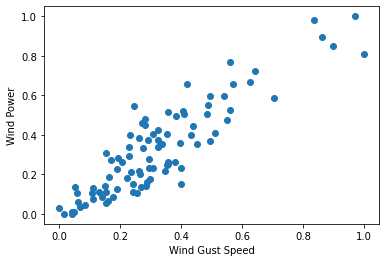

In [9]:
#correlation speed and power
corr_speed_power, _ = pearsonr(df_SE3_normalized.WindGustSpeed, df_power_normalized.SE3)
print(corr_speed_power)
plt.scatter(df_SE3_normalized.WindGustSpeed, df_power_normalized.SE3 )
plt.xlabel("Wind Gust Speed")
plt.ylabel("Wind Power")

##### Wind power is highly correlated to wind speed.

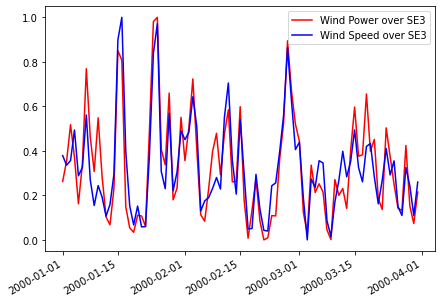

In [10]:
#wind power vs wind speed over SE3 region
plt.figure(figsize=(7,5))
plt.plot(df_power_normalized.SE3, 'r')
plt.plot(df_SE3_normalized.WindGustSpeed, 'b')
plt.gcf().autofmt_xdate()
plt.legend(['Wind Power over SE3', 'Wind Speed over SE3'])

##### We saw speed and power are highly correlated but in above graph, we can seee some anomalies ---- plot in these ranges seperately
#####  wind speed has lower peak, less speed >> wind power generated has high peak , more power:
`between 1st Jan-15th Jan`  `between 1st Feb-15th Feb`

#####  windspeed has high peak, high speed >> wind power has lower peak, low power:
`between 1st Mar-15th Mar`

##### maximum power
`near 15th Jan`
`between 15th Jan-1st Feb`
`near 3rd Mar`

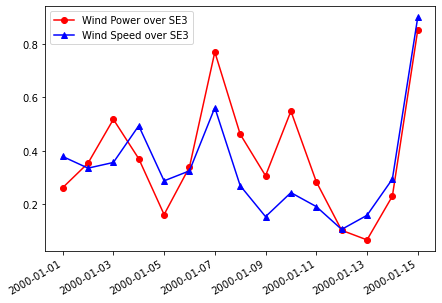

In [11]:
plt.figure(figsize=(7,5))
plt.plot(df_power_normalized.loc['2000-01-01':'2000-01-15']['SE3'], 'r', marker='o')
plt.plot(df_SE3_normalized.loc['2000-01-01':'2000-01-15']['WindGustSpeed'], 'b', marker='^')
plt.gcf().autofmt_xdate()
plt.legend(['Wind Power over SE3', 'Wind Speed over SE3'])

`3rd Jan-- small increase in speed increases power to about 0.5, 
4th Jan-- speed changes about from 0.3 to 0.5 but power reduces about from 0.55 to 0.35--anomaly'

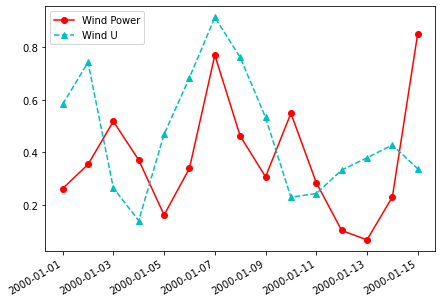

In [12]:
plt.figure(figsize=(7,5))
plt.plot(df_power_normalized.loc['2000-01-01':'2000-01-15']['SE3'], 'r', marker='o')
plt.plot(df_SE3_normalized.loc['2000-01-01':'2000-01-15']['Wind_U'], 'c--', marker='^')
#plt.plot(df_SE3_normalized.loc['2000-01-01':'2000-01-15']['WindGustSpeed'], 'b', marker='o')
#plt.plot(df_SE3_normalized.loc['2000-01-01':'2000-01-15']['Wind_V'], 'g--', marker='^')
plt.gcf().autofmt_xdate()
plt.legend(['Wind Power', 'Wind U', 'Wind Speed SE3', 'Wind V '])

`Wind U is wind direction towards east .i.e flowing towards east` `on 4th Jan this component of wind is lesser than 3rd Jan and wind speed we can see has increased frm 3rd jan to 4th Jan but wind power has reduced on 4th from 3rd Jan from about 0.5 to 0.35`

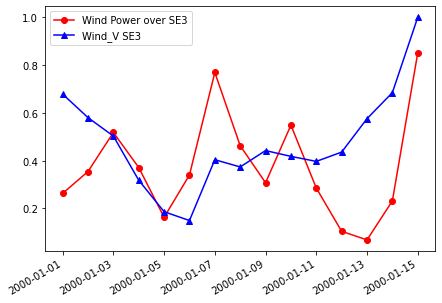

In [13]:
plt.figure(figsize=(7,5))
plt.plot(df_power_normalized.loc['2000-01-01':'2000-01-15']['SE3'], 'r', marker='o')
plt.plot(df_SE3_normalized.loc['2000-01-01':'2000-01-15']['Wind_V'], 'b', marker='^')
plt.gcf().autofmt_xdate()
plt.legend(['Wind Power over SE3', 'Wind_V SE3'])

In [14]:
#leave

0.0734414891952744


Text(0, 0.5, 'Wind Power')

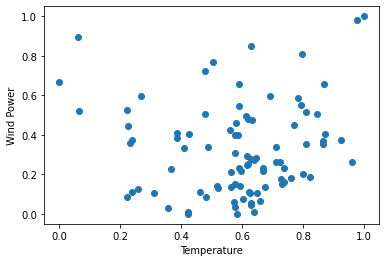

In [15]:
#coorelation temp and power
corr_temp_power, _ = pearsonr(df_SE3_normalized.Temperature, df_power_normalized.SE3)
print(corr_temp_power)
plt.scatter(df_SE3_normalized.Temperature, df_power_normalized.SE3 )
plt.xlabel("Temperature")
plt.ylabel("Wind Power")

###### Correlation value between temperature  and Wind Power over SE3 region is very less, hence not much correlated. 

0.07392594987854938


Text(0, 0.5, 'Wind Power')

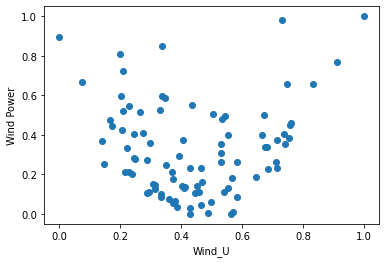

In [16]:
corr_temp_power, _ = pearsonr(df_SE3_normalized.Wind_U, df_power_normalized.SE3)
print(corr_temp_power)
plt.scatter(df_SE3_normalized.Wind_U, df_power_normalized.SE3 )
plt.xlabel("Wind_U")
plt.ylabel("Wind Power")

###### Correlation value between Wind_U  and Wind Power over SE3 region is very less, hence not much correlated. 

0.28528393643607836


Text(0, 0.5, 'Wind Power')

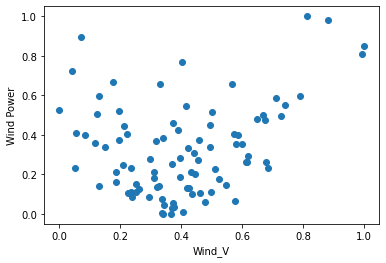

In [17]:
corr_temp_power, _ = pearsonr(df_SE3_normalized.Wind_V, df_power_normalized.SE3)
print(corr_temp_power)
plt.scatter(df_SE3_normalized.Wind_V, df_power_normalized.SE3 )
plt.xlabel("Wind_V")
plt.ylabel("Wind Power")

###### Correlation value between Wind_V  and Wind Power over SE3 region is very less, hence not much correlated. 

In [18]:
#leave

-0.1050297309789395


Text(0, 0.5, 'Wind Power')

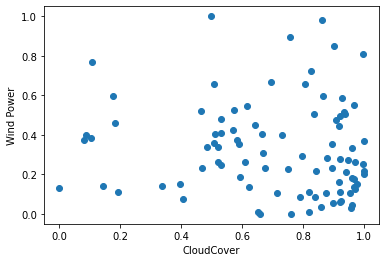

In [19]:
corr_temp_power, _ = pearsonr(df_SE3_normalized.CloudCover, df_power_normalized.SE3)
print(corr_temp_power)
plt.scatter(df_SE3_normalized.CloudCover, df_power_normalized.SE3 )
plt.xlabel("CloudCover")
plt.ylabel("Wind Power")

###### Correlation value between Cloud Cover  and Wind Power over SE3 region is very less, hence not much correlated. 

In [20]:
#leave

-0.036880819884033786


Text(0, 0.5, 'Wind Power')

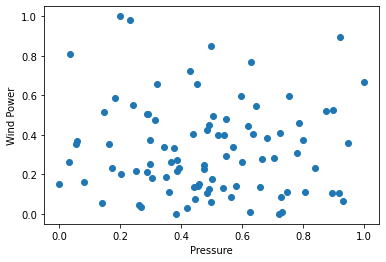

In [21]:
corr_temp_power, _ = pearsonr(df_SE3_normalized.Pressure, df_power_normalized.SE3)
print(corr_temp_power)
plt.scatter(df_SE3_normalized.Pressure, df_power_normalized.SE3 )
plt.xlabel("Pressure")
plt.ylabel("Wind Power")

###### Correlation value between Pressure  and Wind Power over SE3 region is very less, hence not much correlated. 

In [22]:
#leave

0.0024580003041643496


Text(0, 0.5, 'Wind Power')

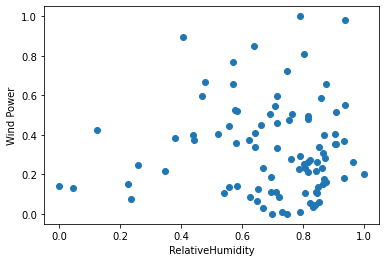

In [23]:
corr_temp_power, _ = pearsonr(df_SE3_normalized.RelativeHumidity, df_power_normalized.SE3)
print(corr_temp_power)
plt.scatter(df_SE3_normalized.RelativeHumidity, df_power_normalized.SE3 )
plt.xlabel("RelativeHumidity")
plt.ylabel("Wind Power")

###### Correlation value between RelativeHumidity  and Wind Power over SE3 region is very less, hence not much correlated. 

In [24]:
#leave

In [25]:
#aggregate wind power data based on agg_func mean for monthly frequency
df_power_ref_M = wind_power_data[(wind_power_data['time'].between('2000-01-01 00:00:00', '2000-03-31 23:00:00'))]
df_power_temp_M = df_power_ref.resample('M', on='time').mean()

In [26]:
#aggregate wind power data based on agg_func mean for monthly frequency
df_SE3_sampled_M = df_en1_SE3.resample('M').mean()
df_SE3_sampled_M

,CloudCover,Pressure,RelativeHumidity,Temperature,WindGustSpeed,Wind_U,Wind_V
time,,,,,,,
2000-01-31,0.786337,100907.359011,0.916017,272.141792,7.418208,0.193451,1.627505
2000-02-29,0.746940,102160.059009,0.878439,268.779769,7.182353,-1.043480,-0.317619
2000-03-31,0.645582,101126.615562,0.818081,270.082519,6.324004,-0.917186,-0.949186


In [27]:
scaler1 = prep.MinMaxScaler()
df_power_normalized_M = df_power_temp_M.copy()
df_power_normalized_M[df_power_normalized_M.columns] = scaler1.fit_transform(df_power_normalized_M[df_power_normalized_M.columns])

df_SE3_normalized_M = df_SE3_sampled_M.copy()
df_SE3_normalized_M[df_SE3_normalized_M.columns] = scaler1.fit_transform(df_SE3_normalized_M[df_SE3_normalized_M.columns])

###### Resampled and Normalised monthly both weather and wind power data for future use when plotting whole year data.
`df_SE3_normalized_M` and `df_power_normalized_M`